In [5]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import diffrax
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
jax.config.update("jax_enable_x64", True)

/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


### Modeling a glucose pulse in Saccharomyces.
Thanks to alot of work from olga we have a pytorch implementation of glycolysis. We will now build the model slightly different, with a matrix S and fluxes v, but the fluxes are defined very similarly to the pytorch project. Workflow
1. Start inspecting data. C1: For glucose_EC, we might need to interpolate. See how we can do this in diffrax.

Text(0.5, 1.0, 'Glucose pulse')

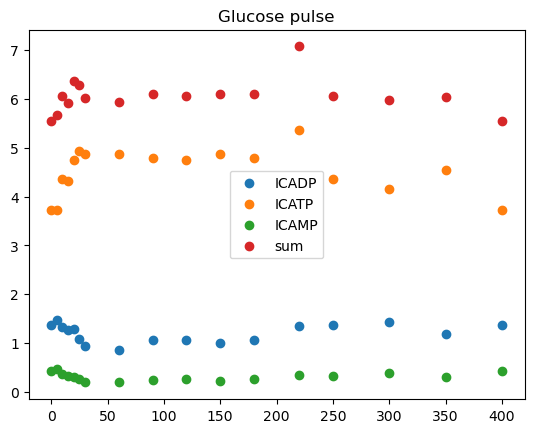

In [6]:
glycolysis_data=pd.read_csv("datasets/VanHeerden_Glucose_Pulse/FF1_timeseries_format.csv",index_col=0).T
time_points=[int(i) for i in glycolysis_data.index.to_list()]

# plt.scatter(time_points,glycolysis_data['ECglucose'],label="ECglucose")
# plt.scatter(time_points,glycolysis_data['ICglucose'],label="ICglucose")
# plt.scatter(time_points,glycolysis_data['ICtreh'],label="ICtreh")
plt.scatter(time_points,glycolysis_data['ICADP'],label="ICADP")
plt.scatter(time_points,glycolysis_data['ICATP'],label="ICATP")
plt.scatter(time_points,glycolysis_data['ICAMP'],label="ICAMP")
plt.scatter(time_points,glycolysis_data['ICAMP']+glycolysis_data['ICADP']+glycolysis_data['ICATP'],label="sum")
# plt.scatter(glycolysis_data.index,glycolysis_data['ICF6P'],label="ICF6P")
plt.legend()
plt.title("Glucose pulse")
# plt.ylabel("Log(Concentration)")
# plt.yscale("symlog")


In [7]:
time_points=[int(i) for i in glycolysis_data.index.to_list()]



EC_glucose_missing=diffrax.linear_interpolation(ts=jnp.array(time_points),
                                                     ys=jnp.array(glycolysis_data['ECglucose']),
                                                     fill_forward_nans_at_end=True)
EC_glucose_interpolation_linear=diffrax.LinearInterpolation(ts=jnp.array(time_points),
                                                     ys=EC_glucose_missing)


coeffs_ECglucose=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ECglucose']),
                                             fill_forward_nans_at_end=True)

EC_glucose_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ECglucose)
                                                    #  ys=EC_glucose_missing)

coeffs_ICtreh=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICtreh']),
                                             fill_forward_nans_at_end=True)

ECtreh_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICtreh)
                                                    #  ys=EC_glucose_missing)



new_ts=jnp.arange(0,400,0.001)
# plt.plot(new_ts,EC_glucose_interpolation_linear.evaluate(t0=new_ts),label="linear interpolation")
# plt.plot(new_ts,EC_glucose_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")
# plt.plot(new_ts,ECtreh_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")
# plt.plot(new_ts,ICATP_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")
plt.plot(new_ts,ICPEP_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")
# plt.scatter(time_points,glycolysis_data['ECglucose'],label="true data ECgluc")
# plt.scatter(time_points,glycolysis_data['ICtreh'],label="true data ICtreh")
# plt.scatter(time_points,glycolysis_data['ICFBP'],label="true data FBP")
plt.scatter(time_points,glycolysis_data['ICPEP'],label="true data ICPEP")
# plt.scatter(time_points,glycolysis_data['ICG3P'],label="true data G3P")
# plt.yscale("symlog")
plt.legend()
plt.title("Interpolation")

NameError: name 'ICPEP_interpolation_cubic' is not defined

In [72]:
params_init

{'f_GLYCEROL_e': Array(0., dtype=float64),
 'f_NTH1': Array(0.002, dtype=float64),
 'f_UGP1': Array(0.00031, dtype=float64),
 'km_sinkDHAP': Array(0.0001, dtype=float64),
 'km_sinkF6P': Array(0.00010679, dtype=float64),
 'km_sinkG6P': Array(0.00919688, dtype=float64),
 'km_sinkGAP': Array(0.00045045, dtype=float64),
 'km_sinkP3G': Array(0.00720244, dtype=float64),
 'km_sinkPEP': Array(0.00090613, dtype=float64),
 'p_ENO1_K2pg': Array(0.06030473, dtype=float64),
 'p_ENO1_Keq': Array(4.09483029, dtype=float64),
 'p_ENO1_Kpep': Array(0.45476028, dtype=float64),
 'p_ENO1_Vm': Array(3.10976041, dtype=float64),
 'p_FBA1_Kdhap': Array(0.02500434, dtype=float64),
 'p_FBA1_Keq': Array(0.10593923, dtype=float64),
 'p_FBA1_Kf16bp': Array(0.82526613, dtype=float64),
 'p_FBA1_Kglyceral3p': Array(3.03463101, dtype=float64),
 'p_FBA1_Vmax': Array(3.67107263, dtype=float64),
 'p_GAPDH_Vmax': Array(81.17666811, dtype=float64),
 'p_GLT_KmGLTGLCi': Array(0.92837915, dtype=float64),
 'p_GLT_KmGLTGLCo': Ar

In [73]:


%reload_ext autoreload
from source.kinetic_mechanisms.JaxKineticMechanisms import  *
from source.kinetic_mechanisms.JaxKineticMechanismsCustom import *
## set up a small term system for state variables
# S=pd.DataFrame(np.array([[-1,1,2]]),index=['ICglucose'],columns=['v_GLT','v_HXK','v_NTH1'])



# S=pd.DataFrame(np.array([[1,-1]]),index=['ICglucose'],columns=['v_GLT','v_HXK'])



GLT_params={'p_GLT_KmGLTGLCi':1.0078,'p_GLT_KmGLTGLCo':1.0078,'p_GLT_VmGLT':8.1327}
# HXK1_params={'p_HXK1_Kglc':0.3483,'p_HXK_Vmax':1 * 6.2548 *(1 + 0)}

HXK1_params={"p_HXK1_Kadp": 0.3492,"p_HXK1_Katp": 0.0931,
    "p_HXK1_Keq": 3.7213e+03,"p_HXK1_Kg6p": 34.7029,
    "p_HXK1_Kglc": 0.3483,"p_HXK1_Kt6p": 0.0073,"p_HXK_Vmax": 1 * 6.2548 * (1 + 0) }


NTH1_params={"p_NTH1_Ktre" : 2.1087,"p_NTH1_kcat" : 4.5132,"f_NTH1" : 0.0020,"p_NTH1_Vmax" : 4.5132 * 0.0020}


PGI_params={ "p_PGI1_Keq": 0.9564,"p_PGI1_Kf6p": 7.2433,"p_PGI1_Kg6p": 33.0689,'p_PGI1_Vmax':1*2.3215*1}
v_sinkG6P_params={'poly_sinkG6P':0.077853600000000,'km_sinkG6P':1e-02} #important, this should be negative in stoichiometry!
v_sinkF6P_params={'poly_sinkF6P':0.024574614000000 ,'km_sinkF6P':1e-04}


PGM1_params={"p_PGM1_Keq": 21.3955,"p_PGM1_Kg1p": 0.0653,"p_PGM1_Kg6p": 0.0324,"p_PGM1_Vmax":8.4574}
TPS1_params={ "p_TPS1_Kg6p": 4.5359,"p_TPS1_Kudp_glc": 0.1268,"p_TPS1_Kpi": 0.7890,"p_TPS1_KmF6P": 1.5631,"p_TPS1_Vmax":9.6164e+03*0.0014}
TPS2_params={"p_TPS2_Kt6p": 0.3686,"p_TPS2_Kpi": 0.7023,"p_TPS2_Vmax": 28.4097 * 0.0013}  # Calculated value for p_TPS2_Vmax
UGP_params={"f_UGP1":3.1000e-04}


PFK_params= {"p_PFK_Camp": 0.0287,"p_PFK_Catp": 1.2822,"p_PFK_Cf16bp": 2.3638,"p_PFK_Cf26bp": 0.0283,"p_PFK_Ciatp": 40.3824,"p_PFK_Kamp": 0.0100,
    "p_PFK_Katp": 1.9971,"p_PFK_Kf16bp": 0.0437,"p_PFK_Kf26bp": 0.0012,"p_PFK_Kf6p": 0.9166,"p_PFK_Kiatp": 4.9332,"p_PFK_L": 1.3886,
    "p_PFK_gR": 1.8127,"p_PFK_F26BP": 1e-3,"p_PFK_Vmax": 1 * 8.7826 * 1  # Calculated as p_PFK_ExprsCor * p_PFK_kcat * f_PFK
}

ALD_params = {
    "p_FBA1_Kdhap": 0.0300,"p_FBA1_Keq": 0.1223,"p_FBA1_Kf16bp": 0.6872,"p_FBA1_Kglyceral3p": 3.5582,"p_FBA1_Vmax": 4.4067 * 1}  # Calculated as p_FBA1_kcat * f_FBA1}


v_sinkGAP={"poly_sinkGAP":0.012626,"km_sinkGAP":5e-04}
TPI1_params = {"p_TPI1_Kdhap": 205.9964,"p_TPI1_Keq": 0.0515,"p_TPI1_Kglyceral3p": 8.8483,"p_TPI1_Vmax":16.1694}


G3PDH_params = {"p_GPD1_Kadp": 1.1069,"p_GPD1_Katp": 0.5573,"p_GPD1_Kdhap": 2.7041,"p_GPD1_Keq": 1.0266e+04,
    "p_GPD1_Kf16bp": 12.7519,"p_GPD1_Kglyc3p": 3.2278,"p_GPD1_Knad": 0.6902,"p_GPD1_Knadh": 0.0322,"p_GPD1_Vmax": 1.7064 * 1}

PGK_params = {"p_PGK_KeqPGK": 3.2348e+03,"p_PGK_KmPGKADP": 0.2064,
    "p_PGK_KmPGKATP": 0.2859,"p_PGK_KmPGKBPG": 0.0031,"p_PGK_KmPGKP3G": 0.4759,
    "p_PGK_VmPGK": 55.1626,"p_PGK_ExprsCor": 1}


GAPDH_params = {
    "p_TDH1_Keq": 0.0054,"p_TDH1_Kglyceral3p": 4.5953,"p_TDH1_Kglycerate13bp": 0.9076,"p_TDH1_Knad": 1.1775,
    "p_TDH1_Knadh": 0.0419,"p_TDH1_Kpi": 0.7731,"p_GAPDH_Vmax": 1 * 78.6422 * (1 + 0 + 0)  # p_GAPDH_ExprsCor * p_TDH1_kcat * (f_TDH1 + f_TDH2 + f_TDH3)
}
vsink3PGA_params={"poly_sinkP3G" : 1e-03,"km_sinkP3G":0.007881000000000} #reverse the sink sign, otherwise it doesnt work

#MODELLING REACTION
vsinkDHAP_params={'poly_sinkDHAP':0.024574614000000 ,"km_sinkDHAP" : 1e-04} #modelling reaction

HOR2_params = {
    "p_HOR2_Kglyc3p": 2.5844,
    "p_HOR2_Kpi": 2.5491,
    "p_HOR2_Vmax": 1.2748 * 1}

GlycT_params={"p_GlycerolTransport" : 0.1001,"f_GLYCEROL_e" : 0.1}

PGM_params = {
    "p_PGM_K2pg": 0.0750,"p_PGM_K3pg": 1.4151,"p_PGM_Keq": 0.1193,"p_PGM_Vm": 11.3652}

ENO1_params={"p_ENO1_K2pg": 0.0567,
    "p_ENO1_Keq": 4.3589,
    "p_ENO1_Kpep": 0.4831,
    "p_ENO1_Vm": 3.3018}

vsinkPEP_params={"km_sinkPEP":1e-03,"poly_sinkPEP":0.007607000000000 } #reverse stoichiometry


# PYK1_params = {
#     "p_PYK1_Kadp": 0.2430,"p_PYK1_Katp": 9.3000,"p_PYK1_Kf16bp": 0.1732,
#     "p_PYK1_Kpep": 0.2810,"p_PYK1_L": 60000,
#     "p_PYK1_hill": 4,"p_PYK1_Vm":9.3167}

# vsinkPYR_params={"poly_sinkPYR":0.161328300000000,"km_sinkPYR":1e-03}


# PDC_params = {"p_PDC1_Kpi": 9.4294,"p_PDC1_Kpyr": 12.9680,
#     "p_PDC1_hill": 0.7242,"p_PDC1_Vmax": 1 * 8.3613 * 0.5290  
# }
# ADH_params = {
#     'p_ADH_KeqADH': 6.8487e-05,'p_ADH_KiADHACE': 0.6431,
#     'p_ADH_KiADHETOH': 59.6935,'p_ADH_KiADHNAD': 0.9677,
#     'p_ADH_KiADHNADH': 0.0316,'p_ADH_KmADHACE': 1.1322,
#     'p_ADH_KmADHETOH': 4.8970,'p_ADH_KmADHNAD': 0.1534,
#     'p_ADH_KmADHNADH': 0.1208,'p_ADH_VmADH': 13.2581
# }
# vsinkACE_params={"poly_sinkACE":2,"km_sinkACE":0.1}



params={**GLT_params,**HXK1_params,**NTH1_params,
        **NTH1_params,**PGI_params,**v_sinkG6P_params,
        **PGM1_params,**TPS1_params,**TPS2_params,
        **v_sinkF6P_params,**UGP_params,
        **PFK_params,**ALD_params,**v_sinkGAP,
        **vsinkDHAP_params,**TPI1_params,**G3PDH_params,
        **GAPDH_params,**PGK_params,**vsink3PGA_params,
        **HOR2_params,**GlycT_params,**PGM_params,
        **ENO1_params,**vsinkPEP_params}
        
        #**vsinkPEP_params,**PYK1_params,
        #**vsinkPYR_params,**PDC_params,**ADH_params,
        #**vsinkACE_params} #remove v_sinkF16P
print("n_parameters",len(params))

#interpolate things we do not wish to model    
coeffs_ECglucose=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ECglucose']),
                                             fill_forward_nans_at_end=True)
EC_glucose_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ECglucose)
                                                    #  ys=EC_glucose_missing)

coeffs_ICtreh=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICtreh']),
                                             fill_forward_nans_at_end=True)
ECtreh_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICtreh)                                                


coeffs_ICATP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICATP']),
                                             fill_forward_nans_at_end=True)
ICATP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICATP)     

coeffs_ICADP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICADP']),
                                             fill_forward_nans_at_end=True)
ICADP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICADP)     

coeffs_ICAMP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICAMP']),
                                             fill_forward_nans_at_end=True)
ICAMP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICAMP)     


coeffs_ICPEP=diffrax.backward_hermite_coefficients(ts=jnp.array(time_points),ys=jnp.array(glycolysis_data['ICPEP']),
                                             fill_forward_nans_at_end=True)
ICPEP_interpolation_cubic=diffrax.CubicInterpolation(ts=jnp.array(time_points),coeffs=coeffs_ICPEP)  

##
v_GLT=Jax_Facilitated_Diffusion(substrate_extracellular='ECglucose',product_intracellular='ICglucose',vmax="p_GLT_VmGLT",km_internal='p_GLT_KmGLTGLCi',km_external='p_GLT_KmGLTGLCo')

v_HXK=Jax_Rev_BiBi_MM_w_Inhibition(substrate1='ICATP',substrate2="ICglucose",product1="ICADP",product2="ICATP",modifier="ICT6P",vmax="p_HXK_Vmax", k_equilibrium="p_HXK1_Keq", km_substrate1="p_HXK1_Katp", 
                                           km_substrate2="p_HXK1_Kglc",
                                           km_product1="p_HXK1_Kadp", km_product2="p_HXK1_Kg6p", ki_inhibitor="p_HXK1_Kt6p")



v_NTH1=Jax_Irrev_MM_Uni(substrate='ICtreh',vmax='p_NTH1_Vmax',km_substrate='p_NTH1_Ktre')
v_PGI=Jax_Rev_UniUni_MM(substrate='ICG6P',product='ICF6P',vmax='p_PGI1_Vmax',k_equilibrium='p_PGI1_Keq',km_substrate='p_PGI1_Kg6p',km_product='p_PGI1_Kf6p')
v_sinkG6P=Jax_MM_Sink(substrate='ICG6P',v_sink='poly_sinkG6P',km_sink='km_sinkG6P')
v_sinkF6P=Jax_MM_Sink(substrate='ICF6P',v_sink='poly_sinkF6P',km_sink='km_sinkF6P')
v_PGM1=Jax_Rev_UniUni_MM(substrate='ICG1P',product='ICG6P',vmax='p_PGM1_Vmax',k_equilibrium='p_PGM1_Keq',km_substrate='p_PGM1_Kg1p',km_product='p_PGM1_Kg6p') #to do v_TPS1 for 2nd rate law

# inhibitor_TPS1=SimpleInhibitor(k_I='p_TPS1_Kpi')
# activator_TPS1=SimpleActivator(k_A="p_TPS1_KmF6P")
# v_TPS1=Jax_Irrev_MM_Bi_w_Modifiers(substrate1="ICG6P",substrate2="ICG1P",modifiers_list=['ICF6P'],vmax="p_TPS1_Vmax",km_substrate1="p_TPS1_Kg6p",
#                                   km_substrate2="p_TPS1_Kudp_glc",modifiers=[activator_TPS1])

v_TPS1=Jax_Irrev_MM_Bi(substrate1="ICG6P",substrate2="ICG1P",vmax="p_TPS1_Vmax",km_substrate1="p_TPS1_Kg6p",km_substrate2="p_TPS1_Kudp_glc")
v_TPS2=Jax_Irrev_MM_Bi_w_Inhibition(substrate="ICT6P",product="ICPHOS",vmax="p_TPS2_Vmax", km_substrate1="p_TPS2_Kt6p", ki="p_TPS2_Kpi")



v_PFK=Jax_Specific(substrate1="ICF6P",substrate2="ICATP",product1="ICFBP",modifier="ICAMP",vmax="p_PFK_Vmax",kr_F6P="p_PFK_Kf6p", kr_ATP="p_PFK_Katp", gr="p_PFK_gR",c_ATP="p_PFK_Catp", ci_ATP="p_PFK_Ciatp", ci_AMP="p_PFK_Camp", 
                           ci_F26BP="p_PFK_Cf26bp", ci_F16BP="p_PFK_Cf16bp", l="p_PFK_L", 
                           kATP="p_PFK_Kiatp", kAMP="p_PFK_Kamp", F26BP ="p_PFK_F26BP",
                           kF26BP = "p_PFK_Kf26bp", kF16BP = "p_PFK_Kf16bp")
v_ALD=Jax_Rev_MM_UniBi(substrate='ICFBP',product1='ICGAP',product2='ICDHAP',vmax="p_FBA1_Vmax", k_equilibrium="p_FBA1_Keq", km_substrate="p_FBA1_Kf16bp",
                                    km_product1="p_FBA1_Kglyceral3p", km_product2="p_FBA1_Kdhap" )
v_TPI1=Jax_Rev_UniUni_MM(substrate="ICDHAP",product="ICGAP",vmax="p_TPI1_Vmax",k_equilibrium="p_TPI1_Keq", km_substrate="p_TPI1_Kdhap",
                                km_product="p_TPI1_Kglyceral3p")
v_sinkGAP=Jax_MM_Sink(substrate="ICGAP",v_sink="poly_sinkGAP",km_sink="km_sinkGAP")

v_G3PDH=Jax_Rev_BiBi_MM_w_Activation(substrate1="ICDHAP",substrate2="ICNADH",product1="ICG3P",product2="ICNAD",modifiers=['ICFBP', 'ICATP', 'ICADP'],vmax="p_GPD1_Vmax", k_equilibrium="p_GPD1_Keq", 
                                             km_substrate1="p_GPD1_Kdhap", km_substrate2="p_GPD1_Knadh",
                                             km_product1="p_GPD1_Kglyc3p", km_product2="p_GPD1_Knad",
                                               ka1="p_GPD1_Kf16bp", ka2="p_GPD1_Katp", ka3="p_GPD1_Kadp")




v_GAPDH=Jax_MM_Ordered_Bi_Tri(substrate1="ICGAP",substrate2="ICNAD",substrate3="ICPHOS",product1="ICBPG",product2="ICNADH",
                              vmax="p_GAPDH_Vmax", k_equilibrium="p_TDH1_Keq", km_substrate1="p_TDH1_Kglyceral3p",
                                      km_substrate2="p_TDH1_Knad", ki="p_TDH1_Kpi", 
                                      km_product1="p_TDH1_Kglycerate13bp", km_product2="p_TDH1_Knadh") #might exchange this mechanism by a BiBi mechanism, since modeling Phos is a bit too much



v_PGK=Jax_Rev_BiBi_MM(substrate1="ICBPG",substrate2="ICADP",product1="IC3PG",product2="ICATP",vmax="p_PGK_VmPGK",k_equilibrium="p_PGK_KeqPGK", 
                               km_substrate1="p_PGK_KmPGKBPG", km_substrate2="p_PGK_KmPGKADP", 
                               km_product1="p_PGK_KmPGKP3G", km_product2="p_PGK_KmPGKATP")


vsink3PGA=Jax_MM_Sink(substrate='IC3PG',v_sink='poly_sinkP3G',km_sink='km_sinkP3G')
#modeling reaction

# v_sinkDHAP=Jax_MM_Sink(substrate="ICDHAP",v_sink="poly_sinkDHAP",km_sink="km_sinkDHAP")

#hor2: might not be quite correct
HOR2_inhibition_Pi=SimpleInhibitor(k_I="p_HOR2_Kpi")
v_HOR2=Jax_Irrev_MM_Uni_w_Modifiers(substrate="ICG3P",vmax="p_HOR2_Vmax",km_substrate="p_HOR2_Kglyc3p",modifiers_list=["ICPHOS"],modifiers=[HOR2_inhibition_Pi])
v_GlycT=Jax_Diffusion(substrate="ICglyc",enzyme="f_GLYCEROL_e",transport_coef="p_GlycerolTransport")


v_PGM=Jax_Rev_UniUni_MM(substrate="IC3PG",product="IC2PG",vmax="p_PGM_Vm", k_equilibrium="p_PGM_Keq",
                                 km_substrate="p_PGM_K3pg", km_product="p_PGM_K2pg")

v_ENO=Jax_Rev_UniUni_MM(substrate="IC2PG",product="ICPEP",vmax="p_ENO1_Vm",k_equilibrium="p_ENO1_Keq",
                                km_substrate="p_ENO1_K2pg", km_product="p_ENO1_Kpep")

vsinkPEP = Jax_MM_Sink(substrate="ICPEP",v_sink="poly_sinkPEP", km_sink="km_sinkPEP") #reverse sign in stoichiometry

# v_PYK1=Jax_Hill_Bi_Irreversible_Activation(substrate1="ICPEP",substrate2="ICADP",activator="ICFBP",product="ICATP",vmax="p_PYK1_Vm", hill="p_PYK1_hill",
#                                                   k_substrate1="p_PYK1_Kpep", k_substrate2="p_PYK1_Kadp",
#                                                   k_product="p_PYK1_Katp", k_activator="p_PYK1_Kf16bp", l="p_PYK1_L")

# vsinkPYR=Jax_MM_Sink(substrate="ICPYR",v_sink="poly_sinkPYR", km_sink="km_sinkPYR")

# v_PDC=Jax_Hill_Irreversible_Inhibition(substrate="ICPYR",inhibitor="ICPHOS",vmax="p_PDC1_Vmax",k_half_substrate="p_PDC1_Kpyr",
#                                                hill="p_PDC1_hill", ki="p_PDC1_Kpi")


# v_ADH=Jax_MM_Ordered_Bi_Bi(substrate1="ICNADH",substrate2="ICETOH",product1="ICACE",product2="ICNADH",vmax="p_ADH_VmADH", k_equilibrium="p_ADH_KeqADH", km_substrate1="p_ADH_KmADHNAD", km_substrate2="p_ADH_KmADHETOH",
#                                    km_product1="p_ADH_KmADHACE", km_product2="p_ADH_KmADHNADH", 
#                                    ki_substrate1="p_ADH_KiADHNAD", ki_substrate2="p_ADH_KiADHETOH", 
#                                    ki_product1="p_ADH_KiADHACE",ki_product2="p_ADH_KiADHNADH")

# vsinkACE=Jax_MM_Sink(substrate="ICACE",v_sink="poly_sinkACE",km_sink="km_sinkACE")

n_parameters 103


TypeError: scatter() missing 1 required positional argument: 'y'

In [92]:
class glycolysis():
    def __init__(self,
                  interpolate_dict):
       self.interpolate_dict=interpolate_dict

    def __call__(self,t,y,args):
        
        params=args


        met_names=['ICG1P',"ICT6P","ICtreh",'ICglucose',
                   'ICG6P','ICF6P',"ICFBP","ICDHAP","ICG3P","ICglyc","ICGAP","ICBPG","IC3PG","IC2PG","ICPEP",'ICNADH',"ICNAD"]#,"ICPEP","ICPYR","ICACE"]
        y=dict(zip(met_names,y))


        y['ECglucose']=self.interpolate_dict['ECglucose'].evaluate(t)
        # y['ICtreh']=self.interpolate_dict['ICtreh'].evaluate(t)
        # y['ICPEP']=self.interpolate_dict['ICPEP'].evaluate(t)
        y['ICATP']=self.interpolate_dict['ICATP'].evaluate(t)
        y['ICADP']=self.interpolate_dict['ICADP'].evaluate(t)
        y['ICAMP']=self.interpolate_dict['ICAMP'].evaluate(t)

        # y['ICATP']=3.73
        # y['ICADP']=1.37
        # y['ICAMP']=0.31
        # y['ICPEP']=1.171415
        # y['ICNADH']=0.0106
        # y["ICNAD"]=1.5794
        y['ICPHOS']=10.0



        eval_dict={**y,**params}
        #modifiers and stuff
        # eval_dict['ICPHOS']

        rate_vGLT=v_GLT(eval_dict)
        rate_vHXK=v_HXK(eval_dict)
        rate_vNTH1=v_NTH1(eval_dict)
        rate_vPGI=v_PGI(eval_dict)

        rate_vsinkG6P=v_sinkG6P(eval_dict)
        rate_vsinkF6P=v_sinkF6P(eval_dict)
        rate_vPGM1=v_PGM1(eval_dict)
        rate_vTPS1=v_TPS1(eval_dict)
        rate_vTPS2=v_TPS2(eval_dict)
        rate_vPFK=v_PFK(eval_dict)
        rate_vALD=v_ALD(eval_dict)

        rate_TPI1=v_TPI1(eval_dict)
        rate_GP3DH=v_G3PDH(eval_dict)
        rate_PGK=v_PGK(eval_dict)
        rate_vsinkGAP=v_sinkGAP(eval_dict)
        rate_GAPDH=v_GAPDH(eval_dict)
        rate_vsink3PGA=vsink3PGA(eval_dict)
        rate_HOR2=v_HOR2(eval_dict)
        rate_vGLycT=v_GlycT(eval_dict)
        rate_PGM=v_PGM(eval_dict)
        rate_ENO=v_ENO(eval_dict)
        rate_vsinkPEP=vsinkPEP(eval_dict)
        # rate_PYK1=v_PYK1(eval_dict)
        # rate_vsinkPYR=vsinkPYR(eval_dict)
        # rate_vPDC=v_PDC(eval_dict)
        # rate_ADH=v_ADH(eval_dict)
        # rate_vsinkACE=vsinkACE(eval_dict)
        
        #modeling rates: checking
        # dATP=

        dG1P=-rate_vPGM1
        dT6P=+rate_vTPS1 -rate_vTPS2
        dICTRE=+rate_vTPS2 -rate_vNTH1
        

        dICglci=+rate_vGLT - rate_vHXK +2*rate_vNTH1

        dICG6P=+rate_vHXK-rate_vPGI -rate_vsinkG6P +rate_vPGM1-rate_vTPS1#we reverse the direction of the sink, since in logspace parameters cannot be negative
        dICF6P=+rate_vPGI +rate_vsinkF6P-rate_vPFK
        dICFBP=+rate_vPFK -rate_vALD

        dICDHAP=+rate_vALD - rate_TPI1 - rate_GP3DH #modelling reaction rate_vsinkDHAP
        dICG3P=+rate_GP3DH-rate_HOR2
        dICGlyc=+rate_HOR2#-rate_vGLycT

        dICGAP=+rate_vALD +rate_TPI1 -rate_vsinkGAP -rate_GAPDH
        dICBPG=+rate_GAPDH -rate_PGK
        dIC3PG=+rate_PGK - rate_vsink3PGA -rate_PGM#reverse the sign of vsink3PGA, it had a negative value, but we do not allow negative parameters
        dIC2PG=+rate_PGM-rate_ENO
        # dIC2PG=0
        dICPEP=+rate_ENO -rate_vsinkPEP#-rate_PYK1 
        # dICPYR= +rate_PYK1 -rate_vsinkPYR -rate_vPDC
        # dICACE= +rate_vPDC -rate_ADH -rate_vsinkACE
        dICNADH=-rate_GP3DH +rate_GAPDH  #v_ADH modeling and v_mito
        dICNAD=+rate_GP3DH -rate_GAPDH  #same



        return jnp.stack([dG1P,dT6P,dICTRE,dICglci,dICG6P,dICF6P,
                          dICFBP,dICDHAP,dICG3P,
                          dICGlyc,dICGAP,dICBPG,dIC3PG,
                          dIC2PG,dICPEP,dICNADH,dICNAD])#,dICPEP,dICPYR,dICACE])


interpolated_mets={'ECglucose':EC_glucose_interpolation_cubic,
                    'ICtreh':ECtreh_interpolation_cubic,
                    "ICATP":ICATP_interpolation_cubic,
                    "ICADP":ICADP_interpolation_cubic,
                    "ICAMP":ICAMP_interpolation_cubic,
                    "ICPEP":ICPEP_interpolation_cubic}



glycolyse=jax.jit(glycolysis(interpolated_mets))
term=diffrax.ODETerm(glycolyse)

ts=jnp.linspace(0,400,1000)

solver = diffrax.Kvaerno5()
saveat=diffrax.SaveAt(ts=ts)
stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-7)


y0_dict={'ICG1P':0.064568,
         "ICT6P":0.093705,
         "ICtreh":63.312040,
         'ICglucose':0.196003,
         'ICG6P':0.716385,
         'ICF6P':0.202293,
         "ICFBP":0.057001,
         "ICDHAP":0.048571,
         "ICG3P":0.020586,
         "ICglyc":0.1,
         "ICGAP":0.006213,
         "ICBPG":0.0001,
         "IC3PG":2.311074,
         "IC2PG":0.297534,
          "ICPEP":1.171415,
          "ICNADH":0.0106,
          "ICNAD":1.5794}
        #  "ICPYR":0.152195,
        #  "ICACE":0.04}


y0=jnp.array(list(y0_dict.values()))


sol = diffrax.diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], 
                          dt0=0.1, 
                          y0=y0,
                          saveat=saveat,
                            stepsize_controller=stepsize_controller,
                            args=params,
                            max_steps=10000)



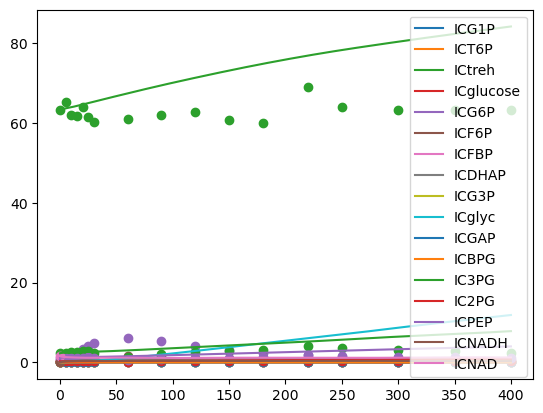

In [94]:
met_names=['ICG1P',"ICT6P","ICtreh",'ICglucose','ICG6P','ICF6P',"ICFBP","ICDHAP","ICG3P","ICglyc","ICGAP","ICBPG","IC3PG","IC2PG","ICPEP","ICNADH","ICNAD"]

ys_df=pd.DataFrame(sol.ys,index=sol.ts,columns=met_names)

# met_names=["ICtreh","ICG1P"]
# met_names=['ICNADH',"ICNAD"]
# met_names=['ICG1P',"ICT6P",'ICglucose','ICG6P','ICF6P',"ICFBP","ICDHAP","ICG3P","ICglyc","ICGAP","ICBPG","IC3PG","IC2PG"]



for met in met_names:
    plt.plot(list(ys_df.index),ys_df[met],label=met)
    try:
        plt.scatter(time_points,glycolysis_data[met])
    except:
        continue

# plt.plot(new_ts,EC_glucose_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")
# plt.plot(new_ts,ECtreh_interpolation_cubic.evaluate(t0=new_ts),label="cubic interpolation")
# plt.scatter(time_points,glycolysis_data['ICglucose'],label="true data ICgluc",c="red")
# plt.scatter(time_points,glycolysis_data['ICG6P'],label="true data ICgluc",c="red")
# plt.scatter(time_points,glycolysis_data['ICG6P'],label="true data ICG6P",c="blue")
# plt.scatter(time_points,glycolysis_data['ICF6P'],label="true data ICF6P",c="green")
# plt.scatter(time_points,glycolysis_data['ICFBP'],label="true data ICFBP",c="black")
# plt.scatter(time_points,glycolysis_data['ICGAP'],label="true data ICGAP",c="grey")
# plt.scatter(time_points,glycolysis_data['ICG1P'],label="true data ICPYR",c="orange")
# plt.scatter(time_points,glycolysis_data['ICtreh'],label="true data ICPEP",c="turquoise")
plt.legend()
# plt.yscale("log")

In [128]:
# log_loss_func=jax.jit(create_log_params_log_loss_func(JaxKmodel))
from source.parameter_estimation.training import *


class NeuralODE():
    def __init__(self,func):

        self.func=func
        self.rtol=1e-3
        self.atol=1e-7
        self.max_steps=200000
        
    def __call__(self,ts,y0,params):
        solution = diffrax.diffeqsolve(
        diffrax.ODETerm(self.func),
        diffrax.Kvaerno5(),
        t0=ts[0],
        t1=ts[-1],
        dt0=0.001,
        y0=y0,
        args=(params),
        stepsize_controller=diffrax.PIDController(rtol=self.rtol, atol=self.atol,pcoeff=0.4,icoeff=0.3,dcoeff=0),
        saveat=diffrax.SaveAt(ts=ts),
        max_steps=self.max_steps)

        return solution.ys


glycolyse=jax.jit(NeuralODE(glycolysis(interpolated_mets)))

met_names=['ICG1P',"ICT6P","ICtreh",'ICglucose','ICG6P','ICF6P',"ICFBP","ICDHAP","ICG3P","ICglyc","ICGAP","ICBPG","IC3PG","IC2PG","ICPEP","ICNADH","ICNAD"]

In [129]:
def create_log_params_loss_func(model,to_include:list):
    """Loss function for log transformed parameters """
    def loss_func(params,ts,ys):
        params=exponentiate_parameters(params)
        mask=~jnp.isnan(jnp.array(ys))
        ys=jnp.atleast_2d(ys)
        y0=ys[0,:]
        y_pred=model(ts,y0,params)
        ys = jnp.where(mask, ys, 0)
        y_pred = jnp.where(mask, y_pred, 0)
    
        ys=ys[:,to_include]
        y_pred=y_pred[:,to_include]

        non_nan_count = jnp.sum(mask)
        
        loss = jnp.sum((y_pred - ys) ** 2) / non_nan_count
        return loss
    return loss_func


In [130]:

def create_log_params_means_centered_loss_func(model,to_include:list):
    """Loss function for log transformed parameters. 
    We do a simple input scaling using the mean per state variable (we add 1 everywhere to prevent division by zero) """
    def loss_func(params,ts,ys):

        params=exponentiate_parameters(params)
        mask=~jnp.isnan(jnp.array(ys))
        ys=jnp.atleast_2d(ys)
        y0=ys[0,:]
        y_pred=model(ts,y0,params)
        ys = jnp.where(mask, ys, 0)

        ys=ys+1
        y_pred=y_pred+1
        scale=jnp.mean(ys,axis=0)

        ys=ys/scale
        y_pred=y_pred/scale

        y_pred = jnp.where(mask, y_pred, 0)


            
        ys=ys[:,to_include]
        y_pred=y_pred[:,to_include]
        # print(ys,y_pred)
        non_nan_count = jnp.sum(mask)

        loss = jnp.sum((y_pred - ys) ** 2) / non_nan_count
        return loss
    return loss_func




log_loss_func=jax.jit(create_log_params_means_centered_loss_func(glycolyse,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]))
# loss_func=jax.jit(create_loss_func(glycolyse))


@jax.jit
def update_log(opt_state,params,ts,ys):
    """Update rule for the gradients for log-transformed parameters. Can only be applied
    to nonnegative parameters"""
    log_params=log_transform_parameters(params)
    loss=log_loss_func(log_params,ts,ys)
    grads=jax.jit(jax.grad(log_loss_func,0))(log_params,ts,ys) #loss w.r.t. parameters
    updates,opt_state=optimizer.update(grads,opt_state)
    #we perform updates in log space, but only return params in lin space
    log_params = optax.apply_updates(log_params, updates)
    lin_params = exponentiate_parameters(log_params) 
    return opt_state,lin_params,loss,grads

# loss_func(params,time_points,jnp.array(glycolysis_data[['ICglucose','ICG6P']]))
glycolysis_data.loc["0",'ICglyc']=0.01
# glycolysis_data.loc[:,'ICBPG']=np.nan
glycolysis_data.loc["0",'ICBPG']=0.01
glycolysis_data.loc["0",'ICNAD']=1.5794
glycolysis_data.loc["0",'ICNADH']=0.0106
# print(glycolysis_data[met_names])

dataset=glycolysis_data[met_names]
dataset=jnp.array(dataset)


log_loss_func(params,time_points,dataset)



Array(1025.85032983, dtype=float64)

In [125]:
# params_init=params
# lr=1e-3
# optimizer = optax.adabelief(lr)
# clip_by_global=optax.clip_by_global_norm(np.log(4))
# optimizer = optax.chain(optimizer,clip_by_global)
# opt_state = optimizer.init(params_init)

# opt_state,params_init,loss,grads=update_log(opt_state,params_init,time_points,
#                                             jnp.array(glycolysis_data[met_names]))

In [126]:
time_points[0:6]

# jnp.array(glycolysis_data[met_names])[0:2].shape

[0, 5, 10, 15, 20, 25]

In [155]:
met_names=['ICG1P',"ICT6P","ICtreh",'ICglucose','ICG6P','ICF6P',"ICFBP","ICDHAP","ICG3P","ICglyc","ICGAP","ICBPG","IC3PG","IC2PG","ICPEP","ICNADH","ICNAD"]
params_init=params
lr=1e-3
optimizer = optax.adabelief(lr)
clip_by_global=optax.clip_by_global_norm(np.log(5))
optimizer = optax.chain(optimizer,clip_by_global)
opt_state = optimizer.init(params_init)

loss_per_iter=[]
print("round 3")
# alpha1=np.linspace(0.2,1.0,2500)
for step in range(1000):
    opt_state,params_init,loss,grads=update_log(opt_state,params_init,time_points,
                                                jnp.array(glycolysis_data[met_names]))
    
    loss_per_iter.append(float(loss))
    if step% 50==0:
        
#           # Scale step to range [0, 1]
#         # print(f"global norm: {global_norm(grads)}")
        print(f"Step {step}, Loss {loss}")





# for step in range(1000):
#     opt_state,params_init2,loss,grads=update_log(opt_state,params_init2,time_points[0:7],jnp.array(glycolysis_data['ICglucose'])[0:3])
#     print(loss)

round 3
Step 0, Loss 0.2901729866383172
Step 50, Loss 0.24316205599283605
Step 100, Loss 0.2225387744097092
Step 150, Loss 0.2162078085565646
Step 200, Loss 0.2145212807053691
Step 250, Loss 0.21304437880974064
Step 300, Loss 0.21153084691677784
Step 350, Loss 0.20971642953734684
Step 400, Loss 0.20745428172612973


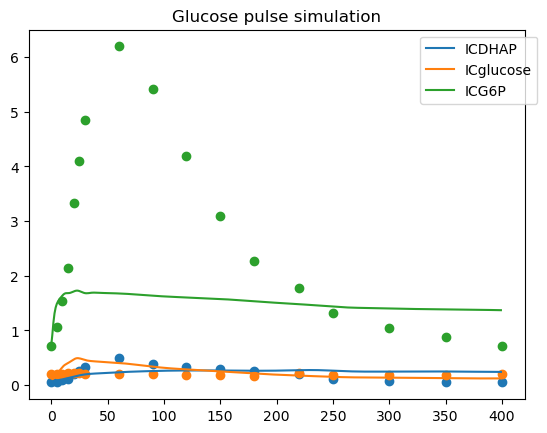

In [154]:

met_names=['ICG1P',"ICT6P","ICtreh",'ICglucose','ICG6P','ICF6P',"ICFBP","ICDHAP","ICG3P","ICglyc","ICGAP","ICBPG","IC3PG","IC2PG","ICPEP","ICNADH","ICNAD"]
ts=jnp.arange(0,400,1)
ys=glycolyse(ts,y0,params_init)
ys=pd.DataFrame(ys,columns=met_names,index=ts)
met_names=["ICDHAP","ICglucose","ICG6P"]

# met_names=['ICNADH','ICNAD']
for metabolite in met_names:
    plt.plot(ts,ys[metabolite],label=metabolite)
    plt.scatter(time_points,glycolysis_data[metabolite])




plt.title("Glucose pulse simulation")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper right")
# plt.show()

# plt.plot(loss_per_iter)
# plt.yscale("symlog")

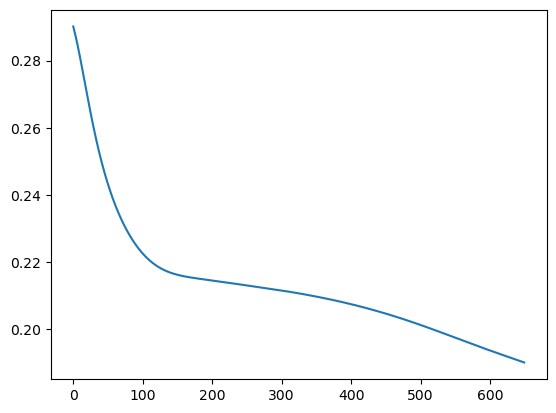

In [152]:
plt.plot(loss_per_iter)
# plt.yscale("symlog")

In [105]:
class glycolysis():
    def __init__(self,
                  interpolate_dict):
       self.interpolate_dict=interpolate_dict

    def __call__(self,t,y,args):
        
        params=args


        met_names=['ICglucose','ICG6P','ICF6P',"ICFBP","ICDHAP","ICG3P","ICglyc","ICGAP","ICBPG","IC3PG","IC2PG","ICPEP"]
        y=dict(zip(met_names,y))


        y['ECglucose']=0.1
        y['ICtreh']=self.interpolate_dict['ICtreh'].evaluate(t)
        # y['ICF6P']=self.interpolate_dict['ICF6P'].evaluate(t)
        # y['ICG1P']=self.interpolate_dict['ICG1P'].evaluate(t)
        y['ICG1P']=0.130
        y['ICATP']=4.52
        y['ICADP']=1.21
        y['ICAMP']=0.31
        y['ICDHAP']=0.048571
        y['ICNADH']=0.0106
        y["ICNAD"]=1.5794
        y['ICG3P']=0.020586
        y['ICPHOS']=10.0


        eval_dict={**y,**params}
        #modifiers and stuff
        # eval_dict['ICPHOS']

        rate_vGLT=v_GLT(eval_dict)
        rate_vHXK=v_HXK(eval_dict)
        rate_vNTH1=v_NTH1(eval_dict)
        rate_vPGI=v_PGI(eval_dict)

        rate_vsinkG6P=v_sinkG6P(eval_dict)
        rate_vsinkF6P=v_sinkF6P(eval_dict)
        rate_vPGM1=v_PGM1(eval_dict)
        rate_vTPS1=v_TPS1(eval_dict)
        rate_vPFK=v_PFK(eval_dict)
        rate_vALD=v_ALD(eval_dict)

        rate_TPI1=v_TPI1(eval_dict)
        rate_GP3DH=v_G3PDH(eval_dict)
        rate_PGK=v_PGK(eval_dict)
        rate_vsinkGAP=v_sinkGAP(eval_dict)
        rate_GAPDH=v_GAPDH(eval_dict)
        rate_vsink3PGA=vsink3PGA(eval_dict)
        rate_HOR2=v_HOR2(eval_dict)
        rate_vGLycT=v_GlycT(eval_dict)
        rate_PGM=v_PGM(eval_dict)
        rate_ENO=v_ENO(eval_dict)
        rate_vsinkPEP=vsinkPEP(eval_dict)
        #modeling rates
  


        dICglci=+rate_vGLT - rate_vHXK +2*rate_vNTH1
        dICG6P=+rate_vHXK-rate_vPGI -rate_vsinkG6P +rate_vPGM1-rate_vTPS1#we reverse the direction of the sink, since in logspace parameters cannot be negative
        dICF6P=+rate_vPGI +rate_vsinkF6P-rate_vPFK
        dICFBP=rate_vPFK -rate_vALD

        dICDHAP=+rate_vALD - rate_TPI1 - rate_GP3DH #modelling reaction rate_vsinkDHAP
        dICG3P=+rate_GP3DH-rate_HOR2
        dICGlyc=+rate_HOR2-rate_vGLycT

        dICGAP=+rate_vALD +rate_TPI1 -rate_vsinkGAP -rate_GAPDH
        dICBPG=+rate_GAPDH -rate_PGK
        dIC3PG=+rate_PGK - rate_vsink3PGA -rate_PGM#reverse the sign of vsink3PGA, it had a negative value, but we do not allow negative parameters
        dIC2PG=+rate_PGM-rate_ENO
        # dIC2PG=0
        dICPEP=+rate_ENO-rate_vsinkPEP


        return jnp.stack([dICglci,dICG6P,dICF6P,
                          dICFBP,dICDHAP,dICG3P,
                          dICGlyc,dICGAP,dICBPG,dIC3PG,
                          dIC2PG,dICPEP])


interpolated_mets={'ECglucose':EC_glucose_interpolation_cubic,
                    'ICtreh':ECtreh_interpolation_cubic}



glycolyse=jax.jit(glycolysis(interpolated_mets))
term=diffrax.ODETerm(glycolyse)

ts=jnp.linspace(0,800,1000)

solver = diffrax.Kvaerno5()
saveat=diffrax.SaveAt(ts=ts)
stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-8)


y0_dict={'ICglucose':0.196003,
         'ICG6P':0.716385,
         'ICF6P':0.202293,
         "ICFBP":0.057001,
         "ICDHAP":0.048571,
         "ICG3P":0.020586,
         "ICglyc":0.1,
         "ICGAP":0.006213,
         "ICBPG":0.0001,
         "IC3PG":2.311074,
         "IC2PG":0.297534,
         "ICPEP":1.171415}


y0=jnp.array(list(y0_dict.values()))


sol = diffrax.diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], 
                          dt0=0.1, 
                          y0=y0,
                          saveat=saveat,
                            stepsize_controller=stepsize_controller,
                            args=params_init,
                            max_steps=100000)


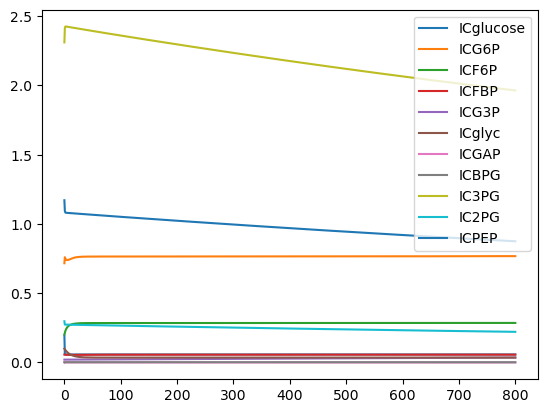

In [106]:
met_names=['ICglucose','ICG6P','ICF6P',"ICFBP","ICDHAP","ICG3P","ICglyc","ICGAP","ICBPG","IC3PG","IC2PG","ICPEP"]
ys=pd.DataFrame(sol.ys,columns=met_names,index=ts)
met_names=['ICglucose','ICG6P','ICF6P',"ICFBP","ICG3P","ICglyc","ICGAP","ICBPG","IC3PG","IC2PG","ICPEP"]
for metabolite in met_names:
    plt.plot(ts,ys[metabolite],label=metabolite)
    # plt.scatter(time_points,glycolysis_data[metabolite])

plt.legend()